<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That is one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.

</div>

# Water Teixeira &lowast; Resolution with lmfit

## Introduction

<div class="alert alert-info">
    
This example shows how to use the <b>water_teixeira</b> model and fit the data using lmfit.
</div>
The data are two sets of water data measured at IN5 (ILL) at 5 &#x212B;.

**Reference:** J. Qvist, H. Schober and B. Halle, *J. Chem. Phys.* **134**, 144508 (2011)

### Physical units

For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

## Import and install required libraries

In [12]:
from __future__ import print_function

import h5py
from scipy.integrate import simps

import numpy as np

import matplotlib.pyplot as plt

# for interactivity (plots, buttons...)
import ipywidgets

# the following line is to remove the warning about too many figures open simultaneously
plt. rcParams.update({'figure.max_open_warning': 0})

from lmfit import Model, Parameters, CompositeModel
from scipy.interpolate import interp1d

%matplotlib widget

## Setting of fitting

### Import reference data and select energy range

In [13]:
path_to_data = './data/'

with h5py.File(path_to_data + 'H2O_293K_5A.hdf', 'r') as f:
    data_in = f['entry1']
    w = data_in['data1']
    x = w['X'][()]  # energy or time values
    unit_w = w['X'].attrs['long_name']
    unit_q = w['Y'].attrs['long_name']
    y = w['DATA'][()] # intensities
    e = w['errors'][()]  # errors for the intensities
    # Obtain the momentum transfer values
    q = w['Y'][()]
    data_5A = dict(q=q, x=x, y=y, e=e)

In [14]:
# number of spectra (i.e. number of different q-values)
nb_q_values = len(data_5A['q'])

### Display units of input data
Just for information in order to determine if a conversion of units is required before using the QENSmodels

In [15]:
print((f"The names and units of `w` (`x`axis) and `q` are: " 
       f"{unit_w[0].decode()} and {unit_q[0].decode()}, respectively."))

The names and units of `w` (`x`axis) and `q` are:  Energy Transfer (meV) and Wavevector Transfer (A!U-1!N), respectively.


### Import resolution data and normalize (unit area)

In [16]:
path_to_data = './data/'

with h5py.File(path_to_data + 'V_273K_5A.hdf', 'r') as f:
    data = f['entry1']
    w = data['data1']  
    res_5A_x = w['X'][()]
    res_5A = np.transpose(w['DATA'][()])

# Force resolution function to have unit area    
for i in range(len(data_5A['q'])):
    area = simps(res_5A[:,i], data_5A['x'])
    res_5A[:,i] /= area

### Mask data according to energy range and filter negative error

In [17]:
# Filter according to energy-range
mask = np.intersect1d(np.where(data_5A['x']>-1.), np.where(data_5A['x']<1.))

f_5A_mask = dict()
f_5A_mask['x'] = np.asarray([data_5A['x'][mask] for i in range(nb_q_values)])
f_5A_mask['y'] = np.asarray([y[mask] for y in data_5A['y']])
f_5A_mask['e'] = np.asarray([e[mask] for e in data_5A['e']])

# Select resolution according to energy range
res_5A_x = res_5A_x[mask]
res_5A = res_5A[mask, :]

In [18]:
# Filter according to negative error values 
# resolution
selected_indices = np.where(f_5A_mask['e'][i] > 0.0)
resol_5A_x = np.asarray([res_5A_x[selected_indices] for i in range(nb_q_values)])
resol_5A = np.asarray([res_5A[selected_indices, i][0] for i in range(nb_q_values)])                             
                              
# data
f_5A = dict()
f_5A['x'] = np.asarray([x[selected_indices] for i, x in enumerate(f_5A_mask['x'])])
f_5A['y'] = np.asarray([y[selected_indices] for i, y in enumerate(f_5A_mask['y'])])
f_5A['e'] = np.asarray([e[selected_indices] for i, e in enumerate(f_5A_mask['e'])])

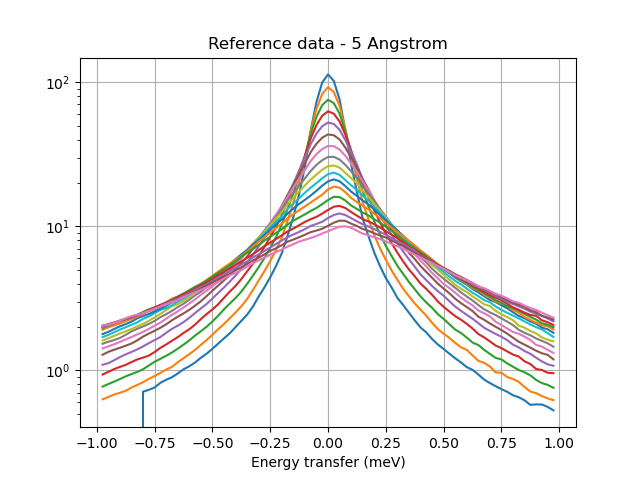

In [19]:
# plot experimental data
fig0, ax0 = plt.subplots()
[ax0.semilogy(f_5A['x'][i], f_5A['y'][i]) for i in range(nb_q_values)]
ax0.set(xlabel=r'Energy transfer (meV)', title='Reference data - 5 Angstrom')
ax0.grid();

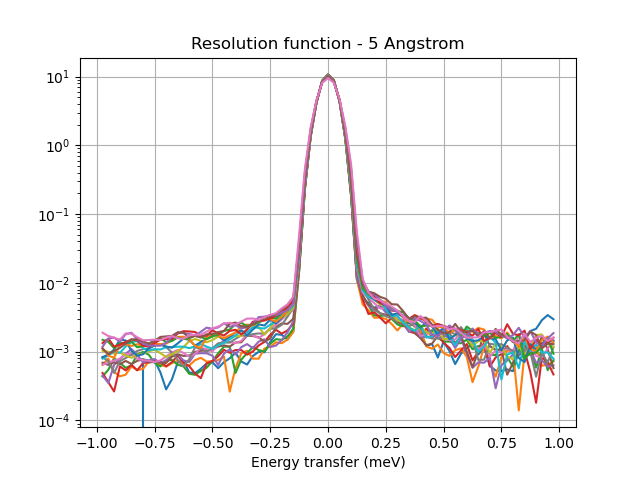

In [20]:
# plot experimental data
fig1, ax1 = plt.subplots()
[ax1.semilogy(resol_5A_x[i], resol_5A[i]) for i in range(nb_q_values)]
ax1.set(xlabel=r'Energy transfer (meV)', title='Resolution function - 5 Angstrom')
ax1.grid(); 

### Create function for instrument resolution data (cubic interpolation between tabulated data points)

In [21]:
f_interp = [interp1d(resol_5A_x[i], 
                     resol_5A[i]/np.sum(resol_5A[i]), 
                     kind='cubic', 
                     bounds_error=False, 
                     fill_value='extrapolate') for i in range(nb_q_values)]

def irf_gate(w, spectrum_nb=0):
    """ Function defined from the interpolation of instrument resolution data 
    Used to define fitting model and plot """ 
    return f_interp[spectrum_nb](w)

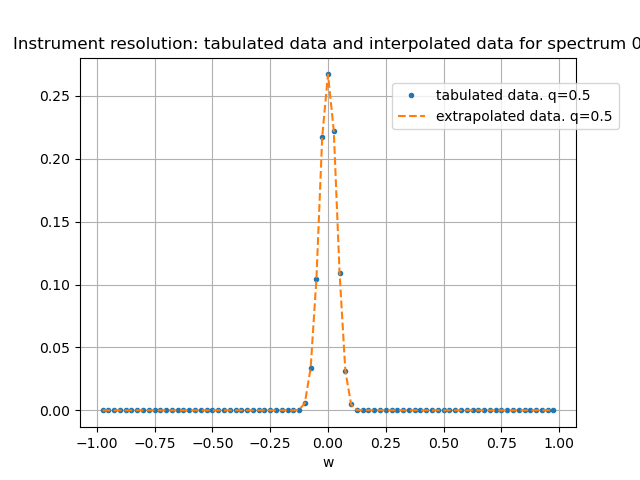

In [23]:
# check interpolation for first spectrum of resolution function: plot tabulated data and interpolated data
indx = 0

fig2, ax2 = plt.subplots()
ax2.plot(resol_5A_x[indx], 
         resol_5A[indx]/np.sum(resol_5A[indx]), 
         '.', 
         label=f"tabulated data. q={data_5A['q'][indx]:.2}")
ax2.plot(f_5A['x'][indx], 
         irf_gate(f_5A['x'][indx], indx), 
         '--', 
         label=f"extrapolated data. q={data_5A['q'][indx]:.2}")
ax2.legend(bbox_to_anchor=(1.1, .95))
ax2.set(xlabel='w', 
        title=f'Instrument resolution: tabulated data and interpolated data for spectrum {indx}')
ax2.grid();

### Create fitting model

In [24]:
import QENSmodels

In [25]:
# Create convolution function 
# code from https://lmfit.github.io/lmfit-py/model.html

def convolve(arr, kernel):
    # simple convolution of two arrays
    npts = min(len(arr), len(kernel))
    pad  = np.ones(npts)
    tmp  = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    
    out  = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]

In [26]:
model = CompositeModel(Model(irf_gate), Model(QENSmodels.sqwWaterTeixeira), convolve) 

print('Names of parameters:', model.param_names)
print('Independent variable(s):', model.independent_vars)

# Define boundaries for parameters to be refined
model.set_param_hint('scale', min=0, max=100)
model.set_param_hint('center', min=-0.1, max=0.1)
model.set_param_hint('D', min=0.05, max=0.25)
model.set_param_hint('resTime', min=0, max=1)
model.set_param_hint('radius', min=0.9, max=1.1)
model.set_param_hint('DR', min=0, max=1)

# Fix some of the parameters
model.set_param_hint('q', vary=False)
model.set_param_hint('spectrum_nb', vary=False)

params = model.make_params()

Names of parameters: ['spectrum_nb', 'q', 'scale', 'center', 'D', 'resTime', 'radius', 'DR']
Independent variable(s): ['w']


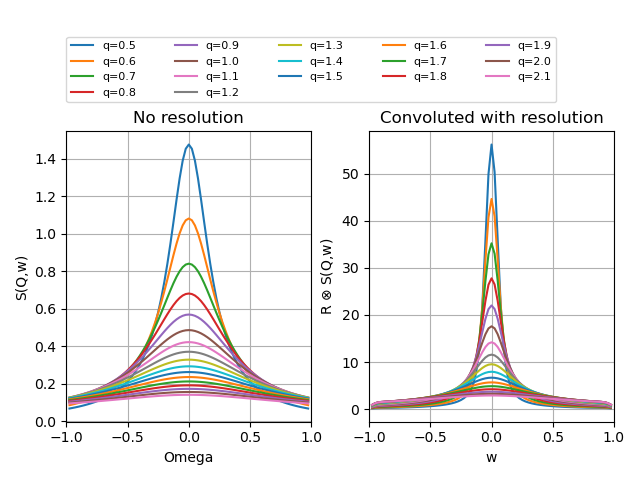

In [28]:
# Plot of the fitting models without and convoluted with the resolution function
# The values of the parameters are specified below. Therefore they could be 
#different from those used in the fitting.

fig, ax = plt.subplots(1,2)
# First subplot
for i in range(nb_q_values):
    xx = f_5A['x'][i]
    ax[0].plot(xx, 
               QENSmodels.sqwWaterTeixeira(xx, 
                                           data_5A['q'][i], 
                                           scale=1, 
                                           center=0, 
                                           D=1, 
                                           resTime=1, 
                                           radius=1, 
                                           DR=1), 
               label=f"q={data_5A['q'][i]:.2}")  

ax[0].grid(True)
ax[0].set(xlabel='Omega', ylabel='S(Q,w)', xlim=(-1, 1), title='No resolution') 
ax[0].tick_params()

plt.tight_layout(rect=[0, 0, 1, 0.8])

ax[0].legend(bbox_to_anchor=(0., 1.1, 2., 0.102), 
             loc='lower right', 
             ncol=5, 
             mode="expand", 
             borderaxespad=0., 
             fontsize=8)

# Second subplot
for i in range(nb_q_values):
    params_plot = model.make_params(nb_spectrum=i, 
                                    q=data_5A['q'][i],
                                    scale=10.,
                                    center=0.,
                                    D=0.13,
                                    resTime=0.1,
                                    radius=1.,
                                    DR=0.3)    
    xx = f_5A['x'][i]
    ax[1].plot(xx, model.eval(params_plot, w=xx))

ax[1].grid(True)
ax[1].set(xlabel='w', 
          ylabel='R $\otimes$ S(Q,w)', 
          xlim=(-1,1), 
          title='Convoluted with resolution')
ax[1].tick_params();

## Running the fit

Run the fit using `lmfit`.

In [29]:
ini_values = {'scale': 10., 
              'center': 0., 
              'D': 0.13, 
              'resTime': 0.1, 
              'radius': 1., 
              'DR': 0.3}

result_fit = [None,] * nb_q_values  # store fits for all spectra

for i in range(nb_q_values):
    params = model.make_params(nb_spectrum=i, 
                               q=data_5A['q'][i],
                               scale=ini_values['scale'], 
                               center=ini_values['center'], 
                               D=ini_values['D'],
                               resTime=ini_values['resTime'],
                               radius=ini_values['radius'],
                               DR=ini_values['DR'])
    
    # Q-independent parameters
    if i==0:
        D_value = params['D'].value
        resTime_value = params['resTime'].value
        radius_value = params['radius'].value
        DR_value = params['DR'].value
    else:
        params['D'].set(value=D_value)
        params['resTime'].set(value=resTime_value)
        params['radius'].set(value=radius_value)
        params['DR'].set(value=DR_value)

    result_fit[i] = model.fit(f_5A['y'][i], 
                              params,
                              w=f_5A['x'][i])

## Showing the results

using methods implemented in `lmfit`

In [30]:
# display result
for i in range(nb_q_values):
    print(f'Result of fit {i}:\n', result_fit[i].fit_report())

Result of fit 0:
 [[Model]]
    (Model(irf_gate) <function convolve at 0x7f81de1534c0> Model(sqwWaterTeixeira))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 79
    # variables        = 6
    chi-square         = 11423.8273
    reduced chi-square = 156.490785
    Akaike info crit   = 404.946689
    Bayesian info crit = 419.163376
##  Warning: uncertainties could not be estimated:
    scale:        at initial value
    D:            at initial value
    resTime:      at initial value
    radius:       at initial value
[[Variables]]
    spectrum_nb:  0 (fixed)
    q:            0.5 (fixed)
    scale:       10.00000000 (init = 10)
    center:       6.0093e-04 (init = 0)
    D:            0.13000000 (init = 0.13)
    resTime:      0.10000000 (init = 0.1)
    radius:       1.00000000 (init = 1)
    DR:           8.6032e-05 (init = 0.3)
Result of fit 1:
 [[Model]]
    (Model(irf_gate) <function convolve at 0x7f81de1534c0> Model(sqwWa

In [ ]:
# plot results using lmfit's features
for i in range(nb_q_values):
    result_fit[i].plot();

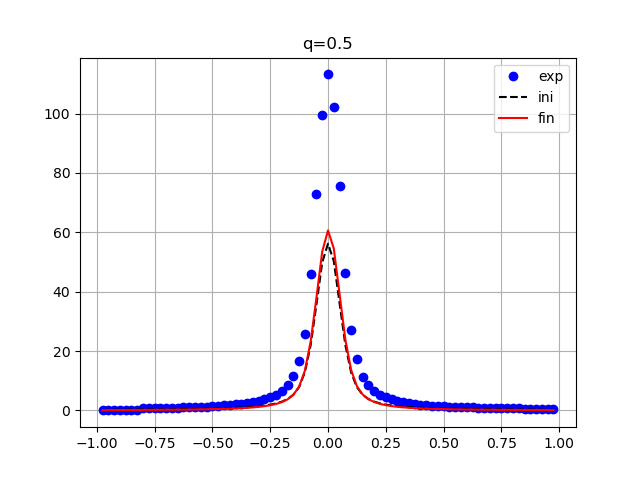

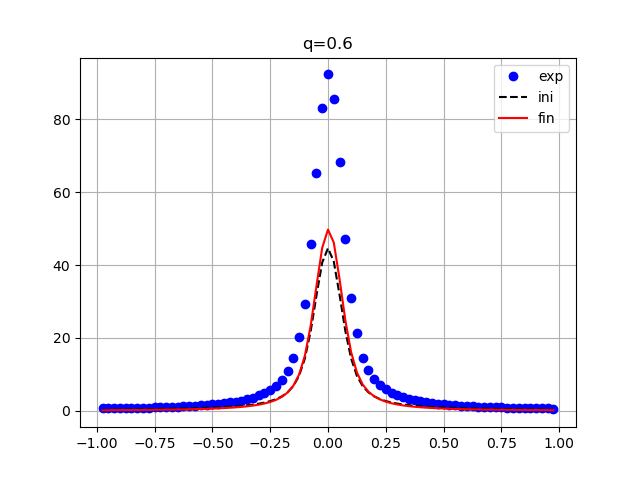

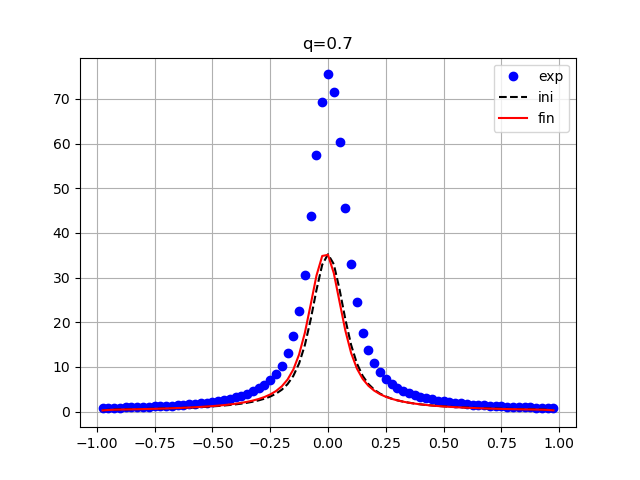

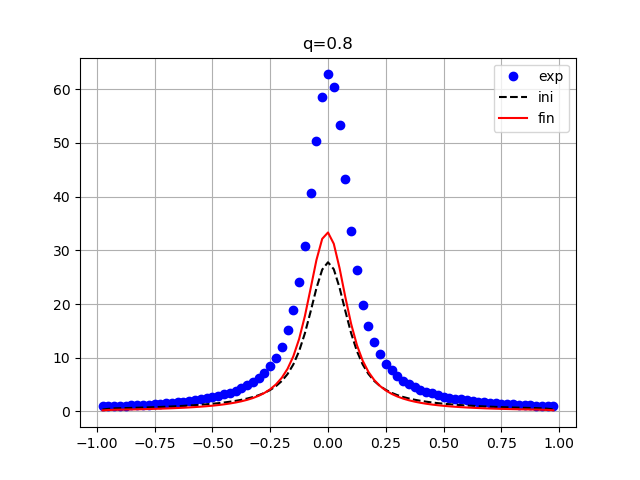

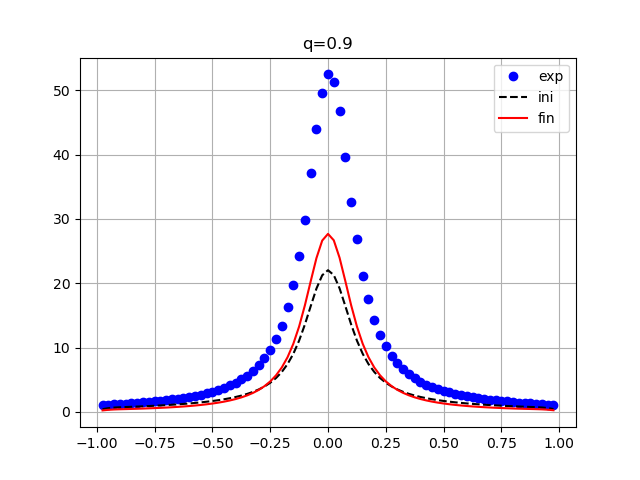

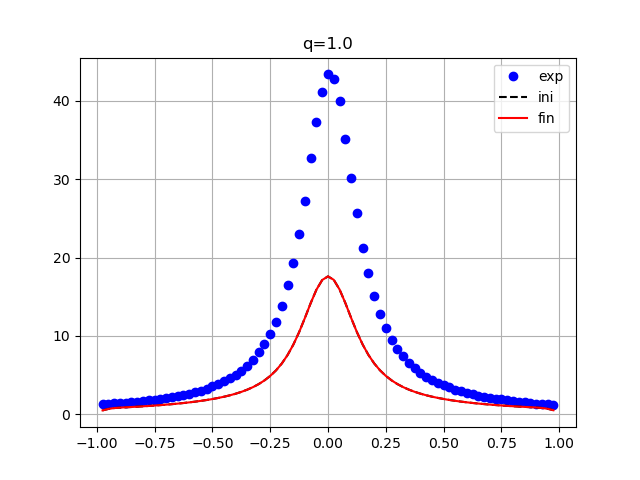

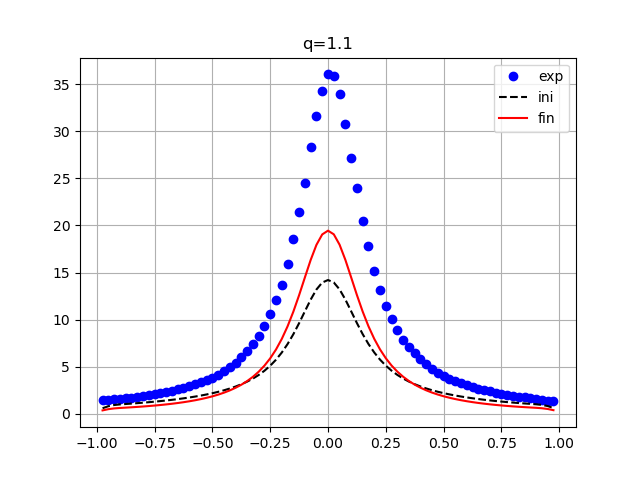

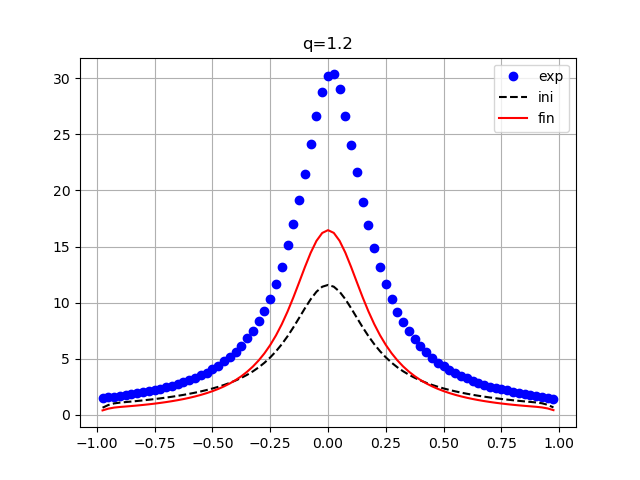

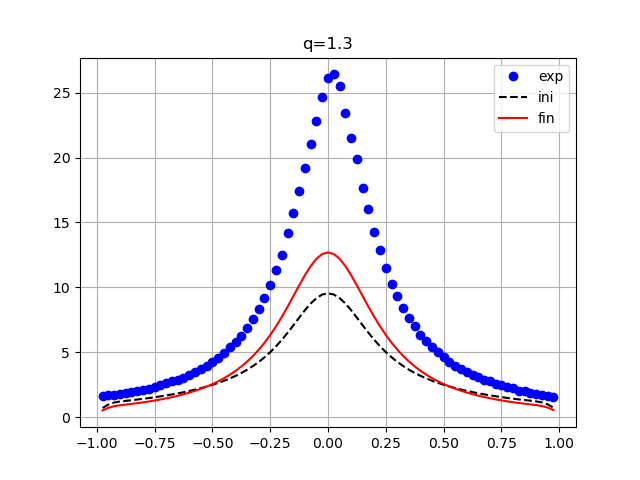

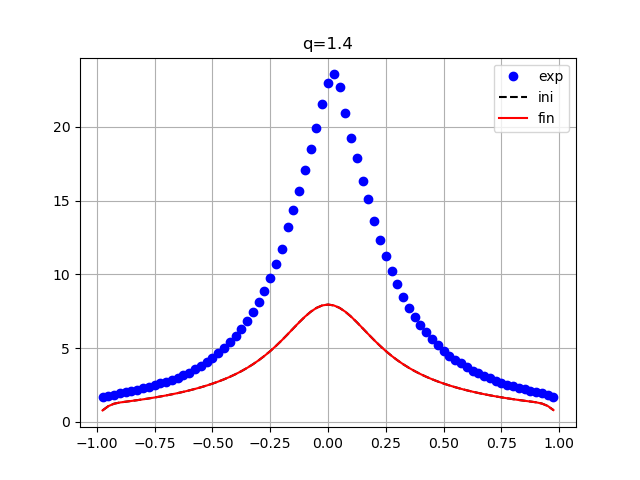

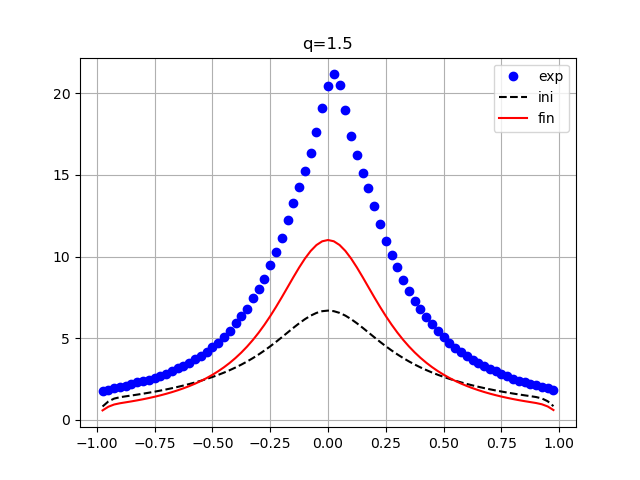

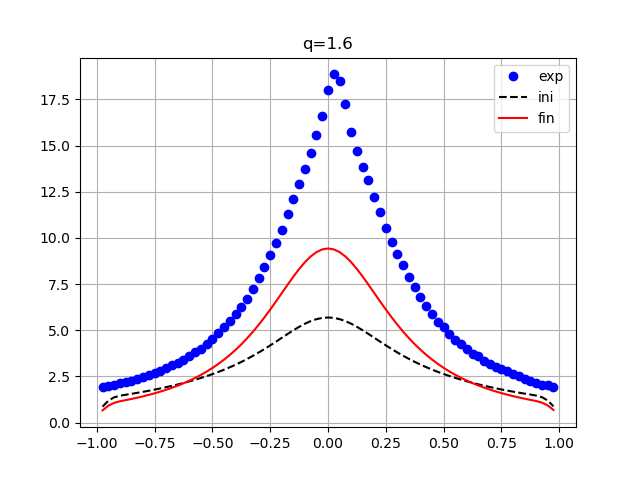

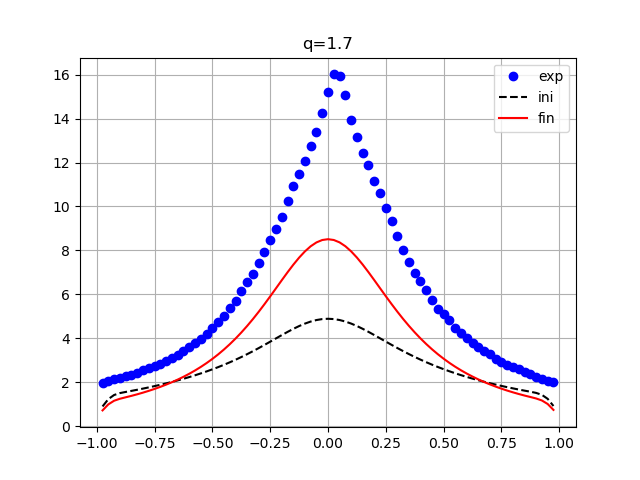

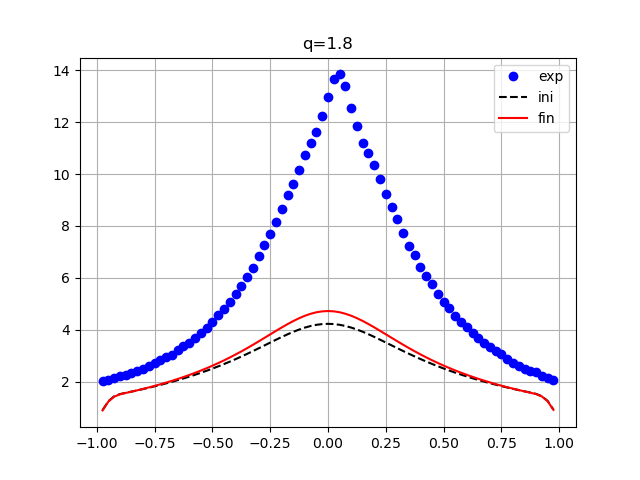

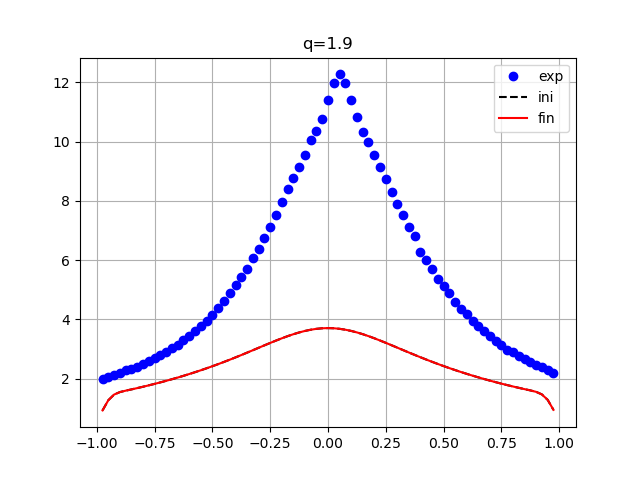

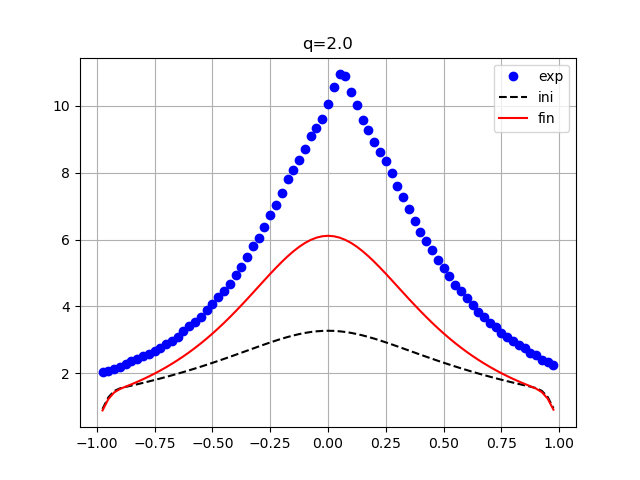

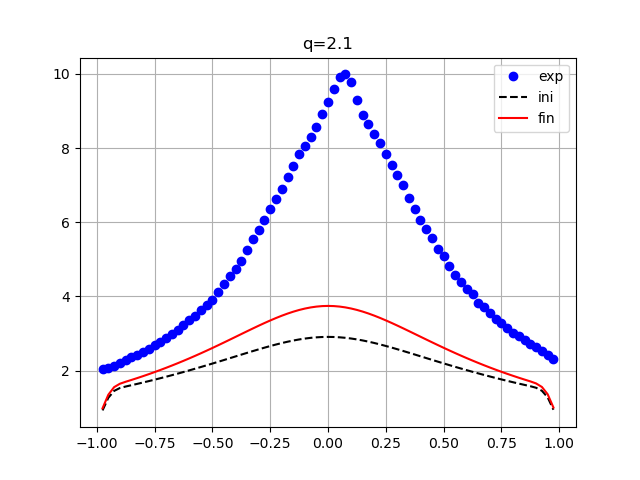

In [31]:
# other option to plot: experimental data, initial fitting model and fitted model for each spectrum

for indx in range(nb_q_values):
    fig1, ax1 = plt.subplots()
    ax1.plot(f_5A['x'][indx], f_5A['y'][indx], 'bo',label='exp')
    ax1.plot(f_5A['x'][indx], result_fit[indx].init_fit, 'k--',label='ini')
    ax1.plot(f_5A['x'][indx], result_fit[indx].best_fit, 'r-', label='fin')
    ax1.set_title(f"q={data_5A['q'][indx]:.2}")
    ax1.legend()
    ax1.grid()